Test integration of GNATSS kalman filter for position interpolation

In [1]:
from es_sfgtools.data_mgmt.data_handler import DataHandler
from es_sfgtools.tiledb_tools.tiledb_schemas import TDBKinPositionArray, TDBShotDataArray, TDBIMUPositionArray
from es_sfgtools.utils.archive_pull import load_site_metadata
from es_sfgtools.modeling.garpos_tools.functions import CoordTransformer
from datetime import datetime, timedelta
import pandas as pd     
import matplotlib.pyplot as plt


# Set up test case
Kin data is stored in TDBKinPositionArray
dfop00 data is stored in TDBShotDataArray
imu data is stored in TDBIMUPositionArray

updated data generated using interpolate_enu_radius_regression

In [2]:
network = 'cascadia-gorda'
station = 'NCC1'
campaign_name = '2023_A_1063'
tdb_dir = f"/Users/mikegottlieb/data/sfg/{network}/{station}/TileDB/"
kin_data = TDBKinPositionArray(tdb_dir + "kin_position.tdb")
dfo_data = TDBShotDataArray(tdb_dir + "shotdata_pre.tdb")
imu_data = TDBIMUPositionArray(tdb_dir + "imu_position.tdb")

site = load_site_metadata(network=network, station=station)
ct = CoordTransformer(site.arrayCenter.latitude, site.arrayCenter.longitude, site.arrayCenter.elevation)
for campaign in site.campaigns:
    if campaign.name == campaign_name:
        start = campaign.start
        end = campaign.end
        print(f"Campaign {campaign.name} from {start} to {end}")

Loading site metadata from https://data.earthscope.org/archive/seafloor/metadata/cascadia-gorda/NCC1.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1063.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1065.json


Campaign 2023_A_1063 from 2023-09-08 11:40:00 to 2023-09-13 19:45:00


In [3]:
dh = DataHandler(directory=f"/Users/mikegottlieb/data/sfg/")
dh.change_working_station(network=network, station=station, campaign=campaign_name)
print(dh.inter_dir)
dh.discover_data_and_add_files(dh.inter_dir)
pipeline, config = dh.get_pipeline_sv3()
pipeline.process_kin()

Built directory structure for cascadia-gorda NCC1 2023_A_1063
No date range set for cascadia-gorda, NCC1, 2023_A_1063
Creating TileDB arrays for NCC1
Consolidating existing TileDB arrays for NCC1
Changed working station to cascadia-gorda NCC1 2023_A_1063
Found 18 files in /Users/mikegottlieb/data/sfg/cascadia-gorda/NCC1/2023_A_1063/intermediate
Added 0 out of 9 files to the catalog
Looking for Kin Files to Process for cascadia-gorda NCC1 2023_A_1063
No Kin Files Found to Process for cascadia-gorda NCC1 2023_A_1063


/Users/mikegottlieb/data/sfg/cascadia-gorda/NCC1/2023_A_1063/intermediate


In [4]:
year = 2023
start = datetime(year, 9, 14)
end = datetime(year, 9, 15)
dfo_df = dfo_data.read_df(start=start)

dfo_df['returnDT'] = pd.to_datetime(dfo_df['returnTime'], unit='s')
dfo_df.set_index('returnDT', inplace=True)
dfo_df.sort_index(inplace=True)
#transform into ENU coordinates
dfo_df['east1_m'], dfo_df['north1_m'], dfo_df['up1_m'] = ct.ECEF2ENU_vec(dfo_df['east1'], dfo_df['north1'], dfo_df['up1'])
dfo_df[dfo_df['transponderID']=='IR5211']

,pingTime,transponderID,head0,pitch0,roll0,head1,pitch1,roll1,east0,north0,...,returnTime,tt,dbv,xc,snr,tat,isUpdated,east1_m,north1_m,up1_m
returnDT,,,,,,,,,,,,,,,,,,,,,
2023-09-14 00:49:59.099683046,1.694653e+09,IR5211,116.659073,-4.997389,-7.068628,119.760132,8.716030,1.932178,-2.733182e+06,-3.912256e+06,...,1.694653e+09,1.659683,-32,43,5.0,0.44,0,-6.691218,-57.602763,-2.553264
2023-09-14 01:21:59.052917957,1.694655e+09,IR5211,270.902573,10.317327,-20.132683,281.493744,-0.240051,-12.868142,-2.733157e+06,-3.912223e+06,...,1.694655e+09,1.612918,-5,78,36.0,0.44,0,-12.514888,10.248859,-2.126021


In [5]:
kin_data.get_unique_dates()

array(['2023-09-14'], dtype='datetime64[D]')

In [9]:
kin_df = kin_data.read_df(start=start, end=end)
# transform into ENU coordinates
kin_df['east_m'], kin_df['north_m'], kin_df['up_m'] = ct.ECEF2ENU_vec(kin_df['east'], kin_df['north'], kin_df['up'])
kin_df

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms,east_m,north_m,up_m
0,2023-09-14 00:00:00.000,41.656512,235.061140,-29.7923,-2.733174e+06,-3.912256e+06,4.217156e+06,8,1.94,NaN,-4.480645,-47.825773,-2.362496
1,2023-09-14 00:00:00.100,41.656512,235.061140,-29.8268,-2.733174e+06,-3.912256e+06,4.217156e+06,8,1.94,NaN,-4.453696,-47.830931,-2.397019
2,2023-09-14 00:00:00.199,41.656512,235.061140,-29.8595,-2.733174e+06,-3.912256e+06,4.217156e+06,8,1.94,NaN,-4.433728,-47.809770,-2.429682
3,2023-09-14 00:00:00.300,41.656513,235.061140,-29.8764,-2.733174e+06,-3.912256e+06,4.217156e+06,8,1.94,NaN,-4.425572,-47.767396,-2.446471
4,2023-09-14 00:00:00.399,41.656513,235.061140,-29.8749,-2.733174e+06,-3.912256e+06,4.217156e+06,8,1.94,NaN,-4.421285,-47.722827,-2.445116
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139440,2023-09-14 03:54:44.400,41.657162,235.061175,-28.4760,-2.733145e+06,-3.912219e+06,4.217211e+06,11,1.39,NaN,-1.501412,24.368420,-1.046077
139441,2023-09-14 03:54:44.499,41.657162,235.061174,-28.7528,-2.733145e+06,-3.912219e+06,4.217210e+06,11,1.39,NaN,-1.622505,24.292800,-1.322909
139442,2023-09-14 03:54:44.600,41.657161,235.061173,-29.0634,-2.733145e+06,-3.912219e+06,4.217210e+06,11,1.39,NaN,-1.744704,24.245994,-1.633484
139443,2023-09-14 03:54:44.699,41.657161,235.061171,-29.3195,-2.733145e+06,-3.912219e+06,4.217210e+06,11,1.39,NaN,-1.889856,24.209566,-1.889526


In [10]:
imu_df = imu_data.read_df(start=start, end=end)
imu_df['east'], imu_df['north'], imu_df['up'] = ct.LLH2ENU_vec(imu_df['latitude'], imu_df['longitude'], imu_df['height'])
imu_df


,time,azimuth,pitch,roll,latitude,longitude,height,latitude_std,longitude_std,height_std,...,upVelocity,northVelocity_std,eastVelocity_std,upVelocity_std,roll_std,pitch_std,azimuth_std,east,north,up
0,2023-09-14 00:00:00.050,106.337802,6.304943,5.266082,41.656524,-124.938848,-30.9102,NaN,NaN,NaN,...,-0.2705,NaN,NaN,NaN,NaN,NaN,NaN,-3.446585,-46.466524,-3.480371
1,2023-09-14 00:00:00.100,106.257269,6.157214,5.641445,41.656524,-124.938848,-30.9244,NaN,NaN,NaN,...,-0.2819,NaN,NaN,NaN,NaN,NaN,NaN,-3.430239,-46.466866,-3.494571
2,2023-09-14 00:00:00.150,106.278723,6.010316,5.728712,41.656524,-124.938848,-30.9387,NaN,NaN,NaN,...,-0.2849,NaN,NaN,NaN,NaN,NaN,NaN,-3.415295,-46.462259,-3.508871
3,2023-09-14 00:00:00.200,106.390815,5.834087,5.469098,41.656525,-124.938847,-30.9527,NaN,NaN,NaN,...,-0.2765,NaN,NaN,NaN,NaN,NaN,NaN,-3.401393,-46.452411,-3.522870
4,2023-09-14 00:00:00.250,106.582078,5.610156,4.911594,41.656525,-124.938847,-30.9657,NaN,NaN,NaN,...,-0.2515,NaN,NaN,NaN,NaN,NaN,NaN,-3.387918,-46.437951,-3.535870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273699,2023-09-14 03:54:44.700,260.834397,-0.992864,3.156542,41.657145,-124.938805,-28.6032,NaN,NaN,NaN,...,-2.6129,NaN,NaN,NaN,NaN,NaN,NaN,0.102188,22.496012,-1.173240
273700,2023-09-14 03:54:44.750,260.867327,-0.221123,2.995195,41.657145,-124.938806,-28.7285,NaN,NaN,NaN,...,-2.4868,NaN,NaN,NaN,NaN,NaN,NaN,0.024984,22.479680,-1.298540
273701,2023-09-14 03:54:44.800,260.968096,0.310373,2.574930,41.657145,-124.938807,-28.8462,NaN,NaN,NaN,...,-2.3365,NaN,NaN,NaN,NaN,NaN,NaN,-0.056323,22.465545,-1.416240
273702,2023-09-14 03:54:44.850,261.112221,0.601482,1.934635,41.657145,-124.938808,-28.9558,NaN,NaN,NaN,...,-2.1707,NaN,NaN,NaN,NaN,NaN,NaN,-0.141402,22.454287,-1.525840


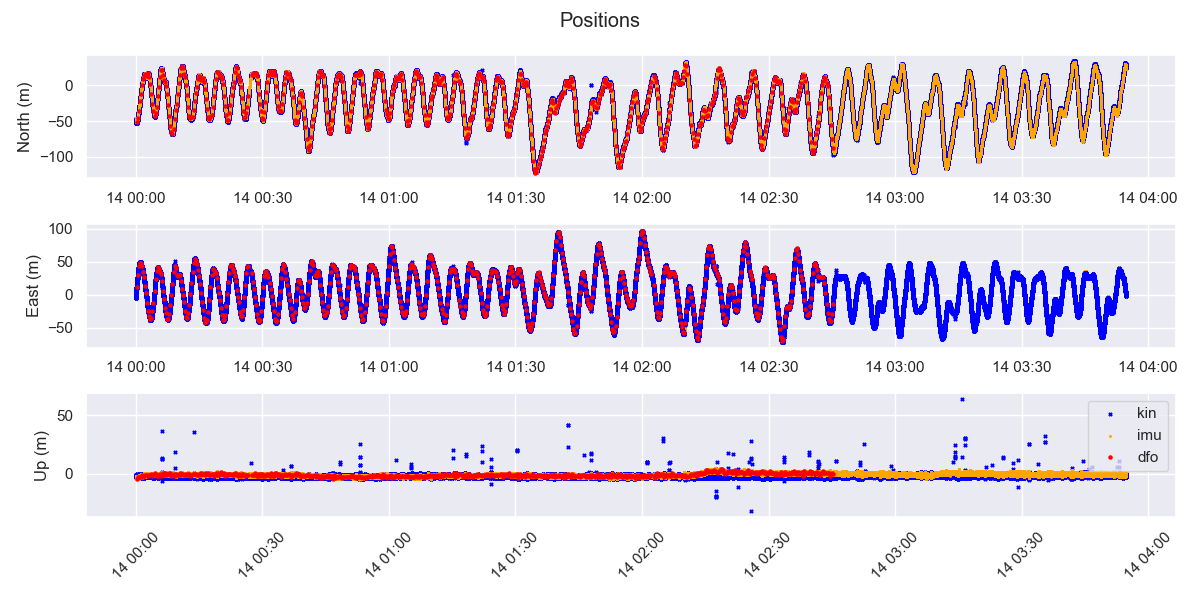

In [8]:
%matplotlib ipympl

s=5
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
axs[0].scatter(kin_df['time'], kin_df['north_m'], label='kin', color='blue', marker='x',s=s)
axs[0].scatter(imu_df['time'], imu_df['north'], label='imu', color='orange', s=s, marker=".")
axs[0].scatter(dfo_df.index, dfo_df['north1_m'], label='dfo', color='red', s=s)
#axs[0].scatter(shotdata_df_updated.index, shotdata_df_updated['north1'], label='updated', color='green', s=s, marker="+")
axs[0].set_ylabel('North (m)')
axs[1].scatter(imu_df['time'], imu_df['east'], label='imu', color='orange', s=s, marker=".")
axs[1].scatter(kin_df['time'], kin_df['east_m'], label='kin', color='blue', s=s, marker='x')
axs[1].scatter(dfo_df.index, dfo_df['east1_m'], label='dfo', color='red', s=s)
#axs[1].scatter(shotdata_df_updated.index, shotdata_df_updated['east1'], label='updated', color='green', s=s, marker="+")
axs[1].set_ylabel('East (m)')
axs[2].scatter(kin_df['time'], kin_df['up_m'], label='kin', color='blue', s=s, marker='x')
axs[2].scatter(imu_df['time'], imu_df['up'], label='imu', color='orange', s=s, marker=".")
axs[2].scatter(dfo_df.index, dfo_df['up1_m'], label='dfo', color='red', s=s)
#axs[2].scatter(shotdata_df_updated.index, shotdata_df_updated['up1'], label='updated', color='green', s=s, marker="+")
axs[2].set_ylabel('Up (m)')

fig.suptitle('Positions')
#ax.set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()
